# Homework 5 - The Marvel Universe!

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict

## 1. Data

### Preprocessing

In [2]:
nodes = pd.read_csv('nodes.csv')

In [3]:
edges = pd.read_csv('edges.csv')

In [4]:
hero = pd.read_csv('hero-network.csv')

Take a look

In [5]:
nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node    19090 non-null  object
 1   type    19090 non-null  object
dtypes: object(2)
memory usage: 298.4+ KB


In [6]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero    96104 non-null  object
 1   comic   96104 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [7]:
hero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


We will not have to deal with NA values, now let's see in what format are the names/words written

In [8]:
nodes.head(10)

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
5,4-D MAN/MERCURIO,hero
6,8-BALL/,hero
7,A '00,comic
8,A '01,comic
9,A 100,comic


In [9]:
nodes.nunique()

node    19090
type        2
dtype: int64

In [10]:
edges.head(10)

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
5,3-D MAN/CHARLES CHAN,H2 252
6,3-D MAN/CHARLES CHAN,M/PRM 35
7,3-D MAN/CHARLES CHAN,M/PRM 36
8,3-D MAN/CHARLES CHAN,M/PRM 37
9,3-D MAN/CHARLES CHAN,WI? 9


In [11]:
edges.nunique()

hero      6439
comic    12651
dtype: int64

In [12]:
hero.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [13]:
hero.nunique()

hero1    6211
hero2    6173
dtype: int64

##### Problems:
 - Some heroes' names in 'hero-network.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'
 - Some heroes' names in 'hero-network.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'
 - The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'
 - Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.

First of all, we remove the extra characters from the neroes' names.

In [14]:
hero["hero1"] = hero["hero1"].str.rstrip('/ ')
hero["hero2"] = hero["hero2"].str.rstrip('/ ')

In [15]:
hero.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [16]:
hero.nunique()

hero1    6206
hero2    6169
dtype: int64

We have less unique values after the rstrip, so there were actually some names that were the same but with extra characters.

Now let's change Spiderman's name in the hero dataframe to the complete 'SPIDER-MAN/PETER PARKER'.

In [17]:
hero[hero["hero1"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'
hero[hero["hero2"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'

In [18]:
print(hero[hero["hero1"]=='SPIDER-MAN/PETER PAR'].shape)
print(hero[hero["hero2"]=='SPIDER-MAN/PETER PAR'].shape)

(0, 2)
(0, 2)


Done! No more short name for Spiderman.

The last problem we have is that some heroes appears to have had a self-collaboration which makes no sense, so we will delete the rows with the same hero in both columns.

In [19]:
hero = hero[hero["hero1"]!=hero["hero2"]]

### Graphs setup

**First graph**: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

First of all, we need to define a metric to calculate the weights so that the heroes with more collaborations has a lower 'cost'. In order to match the number of collaborations with an appropriate weight, we can use the inverse of the normalized number of collaborations for each hero. Just applying (max - X) / (max - min) to each value, we will obtain a 'cost' scaled between 0 and 1, meaning that if a collaboration has a weight close to 0 it is much more important than a collaboration with a weight close to 1.

We create a column with the number of collaboration for each pair of heroes.

In [20]:
hero['number of coll'] = hero.groupby(['hero1', 'hero2'])['hero1'].transform('count')

In [21]:
hero

,hero1,hero2,number of coll
0,"LITTLE, ABNER",PRINCESS ZANDA,5
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4
3,"LITTLE, ABNER",PRINCESS ZANDA,5
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4
...,...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO,15
574463,CALLISTO,ROGUE,10
574464,CALLISTO,CALIBAN,5
574465,CALIBAN,ROGUE,6


We will use it only to compute the normalization, then we will delete it.

In [22]:
MAX = hero['number of coll'].max()

In [23]:
MIN = hero['number of coll'].min()

In [24]:
print(MAX)
print(MIN)

1267
1


In [25]:
hero['weight'] = (MAX - hero['number of coll'])/(MAX - MIN)

In [26]:
hero.head(15)

,hero1,hero2,number of coll,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,5,0.99684
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4,0.99763
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4,0.99763
3,"LITTLE, ABNER",PRINCESS ZANDA,5,0.99684
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4,0.99763
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4,0.99763
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC",2,0.99921
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA",1,1.00000
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK,1,1.00000
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.,1,1.00000


In [27]:
hero = hero.drop('number of coll', axis=1)

In [28]:
hero

,hero1,hero2,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,0.996840
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.997630
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,0.997630
3,"LITTLE, ABNER",PRINCESS ZANDA,0.996840
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.997630
...,...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO,0.988942
574463,CALLISTO,ROGUE,0.992891
574464,CALLISTO,CALIBAN,0.996840
574465,CALIBAN,ROGUE,0.996051


Now we will use the NetworkX package and functions to create our graph.

In [29]:
graph1 = nx.from_pandas_edgelist(hero, 'hero1', 'hero2', edge_attr='weight')

**Second graph**: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

In [30]:
graph2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')

In [31]:
graph2.add_nodes_from(nodes['node'], type=nodes['type'])

## 2. Backend Implementation

### *Functionality 1 - Extract the graph's features*


In [32]:
def top_N(df, N):
    return df.groupby('hero').count().sort_values(['comic'], ascending = False).iloc[:N]

In [33]:
top_N(edges, 10)['comic']

hero
SPIDER-MAN/PETER PARKER    1577
CAPTAIN AMERICA            1334
IRON MAN/TONY STARK        1150
THING/BENJAMIN J. GR        963
THOR/DR. DONALD BLAK        956
HUMAN TORCH/JOHNNY S        886
MR. FANTASTIC/REED R        854
HULK/DR. ROBERT BRUC        835
WOLVERINE/LOGAN             819
INVISIBLE WOMAN/SUE         762
Name: comic, dtype: int64

In [34]:
edges.groupby('comic').count().sort_values(['hero'], ascending= False)

,hero
comic,
COC 1,111
IW 3,91
IW 1,90
H2 279,87
IW 4,80
...,...
MYSTIC COMICS 10,1
N 2/4,1
N 37,1


The output for this functionality must contain:
- the number of nodes in the network (if type 2, report for both node types)
- the number of collaborations of each superhero with the others (*! Only if type 1*)
- the number of heroes that have appeared in each comic (*! Only if type 2*)
- the network's density
- the network's degree distribution
- the average degree of the network
- the network's hubs
- whether the network is spares or dense

let's define some functions

In [35]:
edges.groupby('comic').count()

,hero
comic,
2001 10,1
2001 8,1
2001 9,1
A '00,23
A '01,9
...,...
YOUNG MEN 26,1
YOUNG MEN 27,1
YOUNG MEN 28,1


#### Density of a graph

Both in the case of graph type 1 and 2, we are dealing with *undirected* graph, thus the density can be computed as: $$d = \frac{2\cdot m}{n \cdot (n-1)}$$
where **n** is the number of nodes and **m** is the number of edges in the graph.

In [36]:
def graph_density(G):
    return 2*len(list(G.edges())) / (len(list(G.nodes()))*(len(list(G.nodes())-1)))

#### Degree Distribution

The degree distribution $P(k)$ of a graph is the fraction of nodes in the network with degree $k$.
<br>

Thus if the there are $n$ nodes in total in a network, and $n_k$ of them have degree $k$, we have: $$P(k)=\frac{n_k}{n}$$



#### Network's hubs

Hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution


#### Sparsity vs. Density

We can say that, if the graph's density is close to 1, the graph **dense**, meanwhile it is **sparse** if the density is close to 0. 


In [37]:
class func1():

    def __init__(self, graph, graph_type, n:int, dataframe=edges):
        self.graph = graph
        self.graph_type = graph_type
        self.n = n
        self.dataframe = dataframe

        top_heroes = edges.groupby('hero', as_index=False).count().sort_values(by='comic',ascending=False).rename(columns={'comic':'Count'})
        toppe = edges[edges['hero'].isin(top_heroes.head(self.n)['hero'])]

        self.n_nodes = pd.unique(toppe['hero']).tolist() + pd.unique(toppe['comic']).tolist()
        self.sub_graph = nx.induced_subgraph(graph, self.n_nodes)
        self.sub_graph.graph_type = graph_type


    def count_nodes(self):

        if self.graph_type == 1:

            if self.n == len(self.graph.nodes()):
                g1 = self.graph
                nodes = set()

                for edge in g1.edges():
                    nodes.add(edge[0])
                    nodes.add(edge[1])

                return len(nodes)
            else:
                g1 = self.sub_graph
                nodes = set()

                for edge in g1.edges():
                    nodes.add(edge[0])
                    nodes.add(edge[1])

                return len(nodes)

        elif self.graph_type == 2:

            if self.n == len(self.graph.nodes()):
                g2 = self.graph
                heroes = set()
                comics = set()

                for edge in g2.edges():

                    heroes.add(edge[0])
                    comics.add(edge[1])
                return len(heroes), len(comics)
            else:
                g2 = self.sub_graph
                heroes = set()
                comics = set()

                for edge in g2.edges():

                    heroes.add(edge[0])
                    comics.add(edge[1])
                return len(heroes), len(comics)



    def count_collaborations(self):

        if self.graph_type == 1:

            if self.n == len(self.graph.nodes()):

                degrees = {}

                for edge in self.graph.edges():
                    if edge[0] not in degrees:
                        degrees[edge[0]] = 0
                    if edge[1] not in degrees:
                        degrees[edge[1]] = 0
                    degrees[edge[0]] += 1
                    degrees[edge[1]] += 1
                
                return degrees
            else:

                degrees = {}

                for edge in self.sub_graph.edges():
                    if edge[0] not in degrees:
                        degrees[edge[0]] = 0
                    if edge[1] not in degrees:
                        degrees[edge[1]] = 0
                    degrees[edge[0]] += 1
                    degrees[edge[1]] += 1
                
                return degrees


        else:
            print('Functionality doesn`t exist for this type of graph')

    def comic_appearence(self):

        if self.graph_type == 2:

            comic_set = {i for i in self.dataframe['comic']}
            comic_count = defaultdict(int)

            for edge in self.graph.edges():

                if edge[0] in comic_set:
                    comic_count[edge[0]] += 1
                if edge[1] in comic_set:
                    comic_count[edge[1]] += 1
            
            return comic_count
        else:
            print('Functionality doesn`t exist for this type of graph')

    def graph_density(self):
        if self.n == len(self.graph.nodes()):
            return 2*len(list(self.graph.edges())) / (len(list(self.graph.nodes()))*(len(list(self.graph.nodes()))-1))
        else:
            return 2*len(list(self.sub_graph.edges())) / (len(list(self.sub_graph.nodes()))*(len(list(self.sub_graph.nodes()))-1))

    def degree_distro(self):

        degree = {}
        if self.n == len(self.graph.nodes()):
            for edge in self.graph.edges():
                if edge[0] not in degree:
                    degree[edge[0]] = 0
                else:
                    degree[edge[0]] += 1
                
                if edge[1] not in degree:
                    degree[edge[1]] = 0
                else:
                    degree[edge[1]] += 1

            distros = {}

            for i in degree:
                distros.update({i: degree[i]/len(degree)})

            return distros
        else:
            for edge in self.sub_graph.edges():
                if edge[0] not in degree:
                    degree[edge[0]] = 0
                else:
                    degree[edge[0]] += 1
                
                if edge[1] not in degree:
                    degree[edge[1]] = 0
                else:
                    degree[edge[1]] += 1

            distros = {}

            for i in degree:
                distros.update({i: degree[i]/len(degree)})

            return distros


    def average_degree(self):
        
        if self.n == len(self.graph.nodes()):
            degree = {}

            for edge in self.graph.edges():
                if edge[0] not in degree:
                    degree[edge[0]] = 0
                else:
                    degree[edge[0]] += 1
                
                if edge[1] not in degree:
                    degree[edge[1]] = 0
                else:
                    degree[edge[1]] += 1

            degree_list = list(degree.values())

            return sum(degree_list)/len(degree)
        else:
            degree = {}

            for edge in self.sub_graph.edges():
                if edge[0] not in degree:
                    degree[edge[0]] = 0
                else:
                    degree[edge[0]] += 1
                
                if edge[1] not in degree:
                    degree[edge[1]] = 0
                else:
                    degree[edge[1]] += 1

            degree_list = list(degree.values())

            return sum(degree_list)/len(degree)


    def find_hubs(self):

        if self.graph_type == 1:

            distro_dict = self.degree_distro()

            percentiles = np.percentile(list(distro_dict.values()), 95)
            
            hubs = [k for k,v in distro_dict.items() if v > percentiles]

            return hubs
        
        elif self.graph_type == 2:

            comic_set = {i for i in self.dataframe['comic']}

            distro_dict = self.degree_distro()

            percentiles = np.percentile(list(distro_dict.values()), 95)
            
            hubs = [k for k,v in distro_dict.items() if v > percentiles and k in comic_set]

            return hubs 



    def check_sparsity(self):
            if self.graph_density() < 0.5:
                return 0
            else:
                return 1



    def visualization(self):

        #number of nodes of the graph
        if self.graph_type == 1:
            n_nodes_dict = dict()

            n_nodes = self.count_nodes()
            n_nodes_dict.update({'Number of Nodes': n_nodes})

    

            print(tabulate(n_nodes_dict.items(),tablefmt="grid"))
        elif self.graph_type == 2:
            data = dict()

            n_heroes, n_comics = self.count_nodes()

            data.update({'Number of Heroes': n_heroes})
            data.update({'Number of Comics': n_comics})

            print("(Graph Type%d) Number of Nodes [Heroes vs. Comics]" %self.graph_type)
            print(tabulate(data.items(), tablefmt="grid"))
        
        else:
            print("Graph Type not defined")
        
        #(Only if type 1) Number of collaborations
        if self.graph_type == 1:
            print("Number of nodes for graph type %d:" %self.graph_type)
            print(tabulate(self.count_collaborations().items(),headers=["Heroe", "Number of Collaborations"],tablefmt="grid"))

        #(Only if type 2) Count comic appeareance
        if self.graph_type == 2:

            colab_list = [(k,v) for k,v in self.comic_appearence().items()]

            print("(Graph Type%d) Number of collaborations: " %self.graph_type)
            print(tabulate(colab_list,tablefmt="grid"))

        #Graph density
        density = dict()
        dens = self.graph_density()

        density.update({'Density': dens})

        print(tabulate(density.items(), tablefmt="grid"))

        #Graph degree distribution

        distro = self.degree_distro()
        distro_list = sorted(list(distro.values()))

        sns.histplot(distro_list)
        plt.title('Degree Distribution')
        #plt.xlim(0,0.01)
        #plt.ylim(0,1500)
        plt.show()

        #Average degree
        avg_degree_dict = dict()

        avg_deg = self.average_degree()

        avg_degree_dict.update({'Average Degree': avg_deg})

        print(tabulate(avg_degree_dict.items(), tablefmt="grid"))

        #Sparsity vs. Dense
        if self.check_sparsity() == 1:
            print("Graph %d is dense" %self.graph_type)
        else:
            print('Graph %d is sparse' %self.graph_type)        

In [41]:
test = func1(graph1, graph_type=1,n=80)

In [42]:
test.count_nodes()

78

In [43]:
test.count_collaborations()

{'QUICKSILVER/PIETRO M': 72,
 'WASP/JANET VAN DYNE': 77,
 'SILVER SURFER/NORRIN': 71,
 'HAWK': 73,
 'SCARLET WITCH/WANDA': 76,
 'IRON MAN/TONY STARK': 76,
 'BANNER, BETTY ROSS T': 67,
 'HULK/DR. ROBERT BRUC': 75,
 'CRYSTAL [INHUMAN]': 69,
 'BEAST/HENRY &HANK& P': 75,
 'PROFESSOR X/CHARLES': 69,
 'CYCLOPS/SCOTT SUMMER': 77,
 'ICEMAN/ROBERT BOBBY': 75,
 'MARVEL GIRL/JEAN GRE': 72,
 'ANGEL/WARREN KENNETH': 77,
 'ANT-MAN/DR. HENRY J.': 76,
 'CAPTAIN AMERICA': 77,
 'JARVIS, EDWIN': 73,
 'VISION': 76,
 'THOR/DR. DONALD BLAK': 76,
 'WONDER MAN/SIMON WIL': 76,
 "BLACK PANTHER/T'CHAL": 71,
 'BLACK WIDOW/NATASHA': 75,
 'HERCULES [GREEK GOD]': 76,
 'MAGNETO/MAGNUS/ERIC': 62,
 'SHE-HULK/JENNIFER WA': 74,
 'DR. STRANGE/STEPHEN': 77,
 'BLACK KNIGHT V/DANE': 72,
 'SUB-MARINER/NAMOR MA': 76,
 'FALCON/SAM WILSON': 70,
 'THING/BENJAMIN J. GR': 76,
 'INVISIBLE WOMAN/SUE': 76,
 'JONES, RICHARD MILHO': 71,
 'MR. FANTASTIC/REED R': 77,
 'HUMAN TORCH/JOHNNY S': 77,
 'WOLVERINE/LOGAN': 77,
 'ODIN [ASGARDIAN]'

In [44]:
test.graph_density()

0.8724608724608724

+-----------------+----+
| Number of Nodes | 78 |
+-----------------+----+
Number of nodes for graph type 1:
+----------------------+----------------------------+
| Heroe                |   Number of Collaborations |
+======================+============================+
| QUICKSILVER/PIETRO M |                         72 |
+----------------------+----------------------------+
| WASP/JANET VAN DYNE  |                         77 |
+----------------------+----------------------------+
| SILVER SURFER/NORRIN |                         71 |
+----------------------+----------------------------+
| HAWK                 |                         73 |
+----------------------+----------------------------+
| SCARLET WITCH/WANDA  |                         76 |
+----------------------+----------------------------+
| IRON MAN/TONY STARK  |                         76 |
+----------------------+----------------------------+
| BANNER, BETTY ROSS T |                         67 |
+----------------------+---

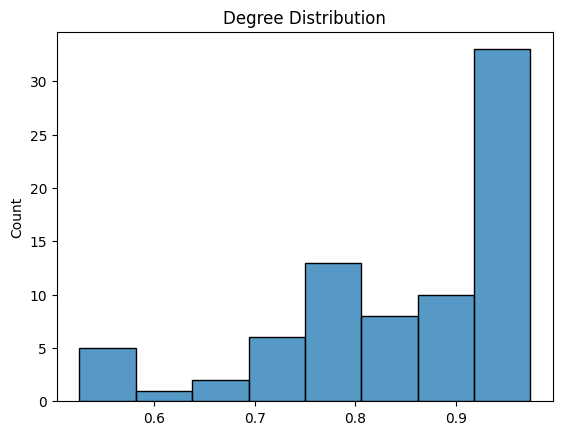

+----------------+---------+
| Average Degree | 66.1795 |
+----------------+---------+
Graph 1 is dense


In [45]:
test.visualization()

In [46]:
test_bis = func1(graph2, graph_type=2, n=10)

(Graph Type2) Number of Nodes [Heroes vs. Comics]
+------------------+------+
| Number of Heroes | 3052 |
+------------------+------+
| Number of Comics | 3977 |
+------------------+------+
(Graph Type2) Number of collaborations: 
+----------------------+-----+
| AA2 35               |   6 |
+----------------------+-----+
| AVF 4                |  11 |
+----------------------+-----+
| AVF 5                |  11 |
+----------------------+-----+
| COC 1                | 111 |
+----------------------+-----+
| H2 251               |   8 |
+----------------------+-----+
| H2 252               |   8 |
+----------------------+-----+
| M/PRM 35             |   1 |
+----------------------+-----+
| M/PRM 36             |   1 |
+----------------------+-----+
| M/PRM 37             |   1 |
+----------------------+-----+
| WI? 9                |   5 |
+----------------------+-----+
| CA3 36               |   4 |
+----------------------+-----+
| CM 51                |  11 |
+----------------------+-

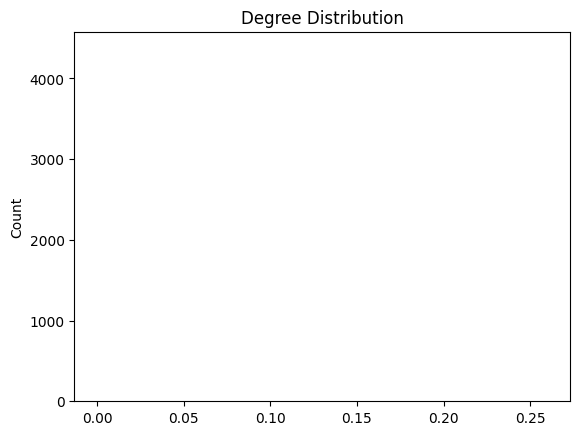

+----------------+---------+
| Average Degree | 2.34577 |
+----------------+---------+
Graph 2 is sparse


In [47]:
test_bis.visualization()

### Functionality 2 - Find top Superheroes

#### Backend implementation

We have to implement a function computing, given a graph, for each node, the given centrality measure. Similarly to the others functionality, it will be possible to select a number N of superheroes to consider (topN heroes: top N heroes to have appeared in the most number of comics). 
We define a function for finding the best (N) superheroes.

In [48]:
#keep only a portion of the graph according to the number of comics a superhero appeared in 
#the csv file to take into account is edges.csv
#it is better to delete nodes from the graph taken as parameter instead of dropping rows from the csv file, since we want to use
#this function in the find_centrality function we will define below 
def topN_comics(graph, N = None): #Note: Whenthe value of N is not set, the function should coonsider the whole data
    if N != None: 
        N_nodes = edges.groupby('hero', as_index= False).count().sort_values('comic', ascending=False).head(N+1)
        list_nodes = list(N_nodes['hero'])
        if nx.is_weighted(graph):
            graph = graph.subgraph(list_nodes)
        else: 
            N_edges = edges[edges['hero'].isin(N_nodes['hero'])] #we want to keep both the heroes and the comics node 
            edge_list = list(N_edges.itertuples(index=False, name = None))
            graph = graph.edge_subgraph(edge_list) 
    return graph



In [49]:
#Backend function for finding the centrality measure

def find_centrality(graph, node, centrality_metric, N = None): 
    graph = topN_comics(graph, N)   #eventually obtain a portion of the graph
    
    if centrality_metric == 'Closeness Centrality':
        print('The centrality you have chosen computes centrality based on the the closeness (consider the shortest path) of a node with respect to the all the others reachable from it')
        if nx.is_weighted(graph):  #graph 1
            centrality_measure = nx.closeness_centrality(graph, distance = 'weight')
            node_centrality = nx.closeness_centrality(graph,node, distance = 'weight')
            if node_centrality >= 0.5: 
                print('%s centrality:' %node, node_centrality)
                print("The value of closeness centrality of the given node %s is high. This means that from that node many other nodes can be reached. In practice, for our particular case, this means that the superhero of interest is connected to many other heroes in the network in the sense that he/she appears in many comics with other superheroes and, if it doesn't, it is 'close' in the network with many others  " %node)
            else: 
                print('%s centrality:' %node, node_centrality)
                print("The value of closeness centrality for the given node %s is low. The superhero in the nework is quite far from others in the network" %node)
        else:                  #graph 2
            centrality_measure = nx.closeness_centrality(graph)
            node_centrality = nx.closeness_centrality(graph,node)
            print('%s centrality:' %node, node_centrality)
            if node_centrality >= 0.5: 
                print("the value of closeness centrality of the given node %s is high. This means that from that node many other nodes can be reached. In practice, for our particular case, this means that the superhero/comic of interest is related (directly or indirectly) to many comics/superheroes  " %node)
            else: 
                print("The value of closeness centrality for the given node %s is low. The superhero in the nework is quite far from others in the network" %node)

    
    
    elif centrality_metric == 'Betweenness Centrality':
        print('The centrality you have chosen computes centrality based on the paths that lead a node to another, passing trough the node of interest ')
        if nx.is_weighted(graph):
            centrality_measure = nx.betweenness_centrality(graph, weight = 'weight')
            node_centrality = centrality_measure[node] 
            print('%s centrality:' %node, node_centrality)

            if node_centrality >= 0.5: 
                print("The value of betwenness centrality of the given node %s is high. This means that from that node many other nodes can be reached in few steps. In practice, for our particular case, this means that the superhero of interest is connected to many other heroes in the network in the sense that he/she appears in many comics with other superheroes and, if it doesn't, it is 'close' in the network with many others  " %node)
            else: 
                print("The value of betweenness centrality for the given node %s is low. The superhero in the network does not represent a crossroad for many paths in the network" %node)
        else:
            centrality_measure = nx.betweenness_centrality(graph)
            node_centrality =centrality_measure[node] 
            print('%s centrality:' %node, node_centrality)  

            if node_centrality >= 0.5: 
                
                print("The value of betweenness centrality for the given node %s is high. This means that the comic/hero in the network is either a comic not only connected to many heroes, but also that these related heroes are in turn connected to many comics" %node)
            else: 
                print("The value of betweenness centrality for the given node %s is low. This means that the the comic/hero does not appear in the shortest paths of the network connected any two nodes" %node)


    elif centrality_metric == 'PageRank Centrality':
        print('The centrality you have chosen computes centrality based on the structure of the (incoming) links')
        if nx.is_weighted(graph):
            centrality_measure = nx.pagerank(graph,alpha = 0.9, weight = 'weight')
            node_centrality = centrality_measure[node]
        else:
            centrality_measure = nx.pagerank(graph,alpha = 0.9)
            node_centrality = centrality_measure[node]   
        print('%s centrality:' %node, node_centrality)
        if node_centrality >= 0.5:
            print("The value of PageRank centrality for the given node %s is high. This means that not only that the node has many links in the network, but also that the connected node are in turn pointed to many others " %node)
        else: 
            print("The value of PageRank centrality for the given node %s is low. >This means that the node of interest is not pointed to many 'relevant' nodes. " %node)


    elif centrality_metric == 'Degree Centrality':
        print('The centrality you have chosen computes centrality based on the degree of the nodes.The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G')
        centrality_measure = nx.degree_centrality(graph)
        node_centrality = centrality_measure[node]
        print('%s centrality:' %node, node_centrality)   
        if node_centrality >= 0.5: 
            print("The value of degree centrality for the node %s is high: it is connected to many other nodes" %node)
        else: 
            print("The value of degree centrality for the node %s is low: it is NOT connected to many other nodes" %node)
    return centrality_measure, node_centrality 

*Note on PageRank centrality* :
 
 The PageRank is defined for directed graphs, but in some special cases applications for undirected graphs occur. In the literature it is widely noted that the PageRank for undirected graphs are **proportional to the degrees of the vertices of the graph**. The PageRank algorithm of networkx was designed for directed graphs but this algorithm does not check if the input graph is directed and will execute on undirected graphs by converting each edge in the directed graph to two edges. 

In [50]:
#test the function with the first graph 
graph_measure1, node_centrality1= find_centrality(graph1, 'CAPTAIN AMERICA', 'Degree Centrality', 18)

The centrality you have chosen computes centrality based on the degree of the nodes.The degree centrality values are normalized by dividing by the maximum possible degree in a simple graph n-1 where n is the number of nodes in G
CAPTAIN AMERICA centrality: 1.0
The value of degree centrality for the node CAPTAIN AMERICA is high: it is connected to many other nodes


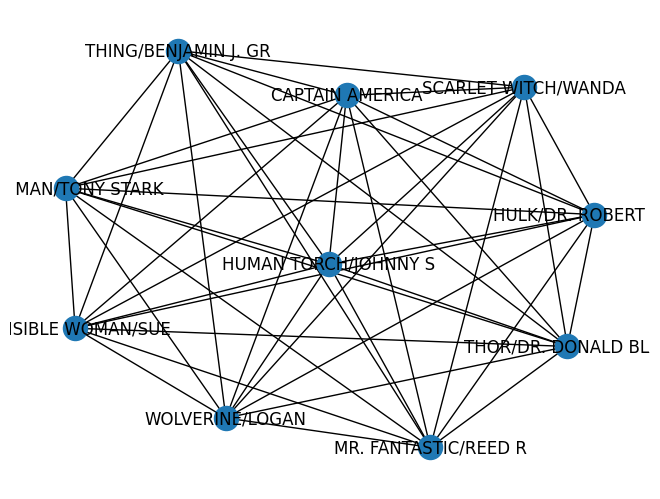

In [51]:
nx.draw(topN_comics(graph1, 10), with_labels = True)

In [ ]:
graph_measure1

In [ ]:
node_centrality1

1.032364453464772

In [ ]:
#test the function with the second graph (Closeness and betweenness centrality measure takes at least 3 min for the second graph to be computed)
graph_measure2, node_centrality2 = find_centrality(graph2, 'CA 312', 'Closeness Centrality', 9)

The centrality you have chosen computes centrality based on the the closeness (consider the shortest path) of a node with respect to the all the others reachable from it
CA 312 centrality: 0.2810615199034982
The value of closeness centrality for the given node CA 312 is low. The superhero in the nework is quite far from others in the network


In [ ]:
graph_measure2

In [ ]:
node_centrality2

0.2810615199034982

#### Frontend implementation

Now, what we want is a table containing a summary of the centrallity measure given by the user. in particular, the information provided to the user should be: 
- the average of the requested centrality measure for ALL the network's NODES
- The requested centrality measure's value for the given node

In [ ]:
#ask the user the query

metric = input("Please, select a metric: ")
nodee = input("Please, choose a node: ")
Y_N = input("Do you want to select only N top superheroes? (Y/N)")
if Y_N == 'Y': 
    N = input('N = ')
else : 
    N = None
centrality_data = pd.DataFrame({'Average_value' : [], 'Node_centrality' : []})
G_measure, N_measure = find_centrality(graph1, nodee, metric, N)

The* centrality you have chosen computes centrality based on the structure of the incoming links


In [ ]:
#compute average score and fill the table
scores = list(G_measure.values())
avg_score = sum(scores)/len(scores)
centrality_data.loc[0, 'Average_value']= avg_score
centrality_data.loc[0, 'Node_centrality'] = N_measure

In [ ]:
#print the table
centrality_data

,Average_value,Node_centrality
0,0.000156,0.005324


_____________

### *Functionality 3 - Shortest ordered Route*

This functionality finds the shortest route between a starting hero-node and a destination hero-node passing through an ordered list of other heroes. 
The idea is to chain shortest path between pairs of subsequent heroes in the given order: we can gather this shortest paths just by tracking the predecessors in a breadth-first-search based shortest path algorithm. Infact the graph which we are working on is undirected and unweightted, so every other approach could be overkilling or completely unesuful without further structures.

Since we are talking of *walks*, we can pass through nodes and edges more than one time, but we have to preserve order. A basic idea is to check whether if the following heroes have already been reached, and eventually perform again the search in the graph obtained dropping that node and its connections. 

The following class implements what has been said above:
- `__init__` is the class builder. It initializes some parameters of the objects, linking the list of heroes to the source and the destination of the ordered route, and importing the dataframe through which we filter the N-top heroes with a simple pandas query. This last structure is implemented in the builder of the class, leading to a list of nodes containing the top N-heroes and related comics and inducing a subgraph on the initial one to have a less complex data structure to work on;
- `shortestPaths` leverages a BFS procedure to retrieve the distances from a starting node and all the other nodes and the related predecessors, which are gathered through a map that is useful to build the path;
- `buildPath` leverages the previous method to build the path between two nodes as a succession of edges.
- `functionality` is the core backend method of the class. It chains shortest paths between subsequent pairs of heroes checking at each iteration if the order is respected. If there isn't such an ordered route, it raises an exception;
- `visualization` is the core frontend method of the class. It visualizes the shortest ordered route both as a list of edges and as the subgraph induced by the heroes involved in our search procedure, assigning to each hero a progressive counter and highlighting the comics as exchange nodes.

In [60]:
class func3():
    def __init__(self, src:str, dst:str, heroes:list, n:int, graph = graph2, dataframe = edges):
        self.dataframe = dataframe
        self.graph = graph
        self.src = src
        self.dst = dst
        self.heroes = [src] + heroes + [dst]
        self.n = n

        top_heroes = edges.groupby('hero', as_index=False).count().sort_values(by='comic',ascending=False).rename(columns={'comic':'Count'})
        toppe = edges[edges['hero'].isin(top_heroes.head(self.n)['hero'])]

        self.n_nodes = pd.unique(toppe['hero']).tolist() + pd.unique(toppe['comic']).tolist()
        self.sub_graph = nx.induced_subgraph(graph, self.n_nodes)
    
    def shortestPaths(self, start):
        visited = {v:False for v in self.sub_graph.nodes}
        dist = {v:0 for v in self.sub_graph.nodes}
        predecessor = {v:None for v in self.sub_graph.nodes}

        Q = [start]
        dist[start] = 0
        visited[start] = True
        predecessor[start] = start
        while len(Q) > 0:
            v = Q.pop(0)
            for u in self.sub_graph.neighbors(v):
                if visited[u] == False:
                    visited[u] = True
                    dist[u] = dist[v] + 1
                    predecessor[u] = v
                    Q.append(u)
                else:
                    continue
        return dist, predecessor
    
    def buildPath(self, start, stop):
        dist, pred = self.shortestPaths(start)
        path = []
        temp = stop
        while temp != start:
            try:
                path.append((pred[temp], temp))
                temp = pred[temp]
            except KeyError:
                return 'There is no such path'
            except nx.NetworkXError:
                return 'There is no such path'
        path.reverse()
        touched_nodes = set([node for edge in path for node in edge])
        return path, touched_nodes

    def functionality(self):
        ordroute = []
        for idx in range(len(self.heroes)-1):
            try:
                _, nodes = self.buildPath(self.heroes[idx], self.heroes[idx+1])
                self.sub_graph = nx.induced_subgraph(self.graph, [node for node in self.n_nodes if node not in self.heroes[idx+2:]])
                walk, _ = self.buildPath(self.heroes[idx], self.heroes[idx+1])
            
                ordroute += walk
                self.sub_graph = nx.induced_subgraph(self.graph, self.n_nodes)
            except KeyError:
                return 'There is no such path'
            except nx.NetworkXError:
                return 'There is no such path'
        return ordroute
    
    def visualization(self):
        ordrou = self.functionality()
        print(ordrou)
        touched_nodes = set([node for edge in ordrou for node in edge])
        heroes = [node for node in touched_nodes if node in self.dataframe['hero'].tolist()]
        comics = [node for node in touched_nodes if node in self.dataframe['comic'].tolist()]

        shortest_route = nx.Graph()
        shortest_route.add_edges_from(ordrou)
        pos = nx.circular_layout(shortest_route)
        pos_labels = {n:(x,y+0.1) for n,(x,y) in pos.items()}

        ordered_labels = {}
        for idx in range(len(self.heroes)):
            ordered_labels[self.heroes[idx]] = (self.heroes[idx],idx)
        comics_labels = {}
        for node in comics:
            comics_labels[node] = node
        
        plt.figure(3,figsize=(16,9)) 

        nx.draw_networkx_nodes(shortest_route, pos, node_size=100, node_color = 'g',nodelist=heroes)
        nx.draw_networkx_nodes(shortest_route, pos, node_size=300, alpha=0.1, nodelist=comics, node_color='r', node_shape='d')
        nx.draw_networkx_edges(shortest_route, pos, alpha=0.2, style='-.')
        nx.draw_networkx_labels(shortest_route, pos_labels,alpha=1,font_size=10, labels=ordered_labels, horizontalalignment='center', verticalalignment='top')    
        nx.draw_networkx_labels(shortest_route, pos,alpha=1,font_weight = 'bold',font_size=12, labels=comics_labels)    

In [61]:
f = func3('CAPTAIN AMERICA', 'THOR/DR. DONALD BLAK', heroes=['HULK/DR. ROBERT BRUC','THING/BENJAMIN J. GR','INVISIBLE WOMAN/SUE','SPIDER-MAN/PETER PARKER'], n=10)

In [62]:
f.functionality()

[('CAPTAIN AMERICA', 'A 1'),
 ('A 1', 'HULK/DR. ROBERT BRUC'),
 ('HULK/DR. ROBERT BRUC', 'A 1'),
 ('A 1', 'THING/BENJAMIN J. GR'),
 ('THING/BENJAMIN J. GR', 'A 1'),
 ('A 1', 'INVISIBLE WOMAN/SUE'),
 ('INVISIBLE WOMAN/SUE', 'A 1.5'),
 ('A 1.5', 'SPIDER-MAN/PETER PARKER'),
 ('SPIDER-MAN/PETER PARKER', 'A 11'),
 ('A 11', 'THOR/DR. DONALD BLAK')]

[('CAPTAIN AMERICA', 'A 1'), ('A 1', 'HULK/DR. ROBERT BRUC'), ('HULK/DR. ROBERT BRUC', 'A 1'), ('A 1', 'THING/BENJAMIN J. GR'), ('THING/BENJAMIN J. GR', 'A 1'), ('A 1', 'INVISIBLE WOMAN/SUE'), ('INVISIBLE WOMAN/SUE', 'A 1.5'), ('A 1.5', 'SPIDER-MAN/PETER PARKER'), ('SPIDER-MAN/PETER PARKER', 'A 11'), ('A 11', 'THOR/DR. DONALD BLAK')]


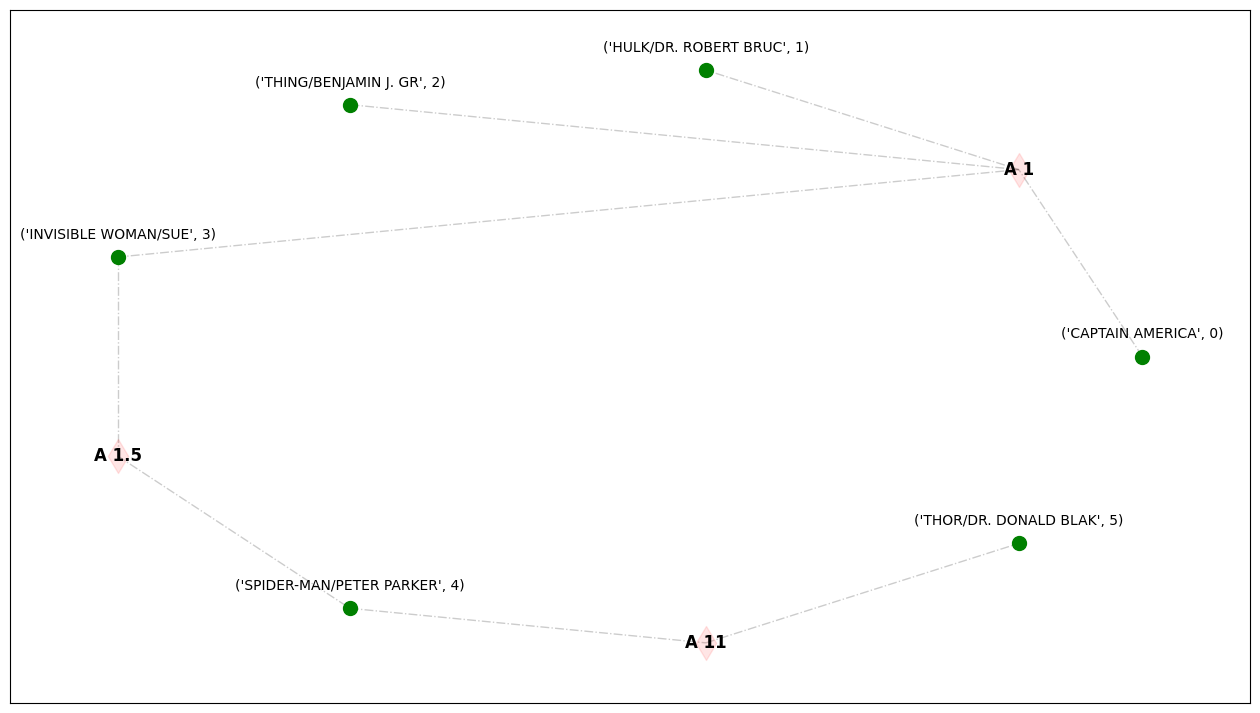

In [63]:
f.visualization()

### *2.4 Functionality 4 - Disconnecting Graph*

Input:
- The graph data
- heroA: a superhero to which will relate sub-graph $G_a$
- heroB: a superhero to which will relate sub-graph $G_b$
- N: denoting the top N heroes that their data should be considered

Output:
- The minimun number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: $G_a$ and $G_b$ 

In order to solve this task, we will use a minimun cut algorithm, which is a way to partition a graph into two subgraphs by removing the smallest possible number of edges.

In [ ]:
class func4():
    
    def __init__(self, graph, heroA, heroB, n:int, dataframe = edges):

        self.graph = graph
        self.heroA = heroA
        self.heroB = heroB
        self.n = n

        self.dataframe = dataframe

        top_heroes = edges.groupby('hero', as_index=False).count().sort_values(by='comic',ascending=False).rename(columns={'comic':'Count'})
        toppe = edges[edges['hero'].isin(top_heroes.head(self.n)['hero'])]

        self.n_nodes = pd.unique(toppe['hero']).tolist() + pd.unique(toppe['comic']).tolist()
        self.sub_graph = nx.induced_subgraph(graph, self.n_nodes)


    # Breadth First Search to search a path from HeroA to HeroB
    
    def minCut(self):

        if self.n == len(self.graph.nodes()):
            cut_edges = nx.minimum_edge_cut(self.graph, self.heroA, self.heroB)
            return cut_edges
        else:
            cut_edges = nx.minimum_edge_cut(self.sub_graph, self.heroA, self.heroB)
            return cut_edges

    def remove_edges(self,cut_edge):

        if self.n == len(self.graph.nodes()):
            for u,v in cut_edge:
                self.graph.remove_edge(u,v)

            return self.graph
        else:
            sub_graph = self.sub_graph.copy()
            for u,v in cut_edge:
                sub_graph.remove_edge(u,v)

            return sub_graph

    def visualization(self):

        cut_edges = self.minCut()

        print("Number of links that have to be disconnected: ", len(cut_edges))

        if self.n == len(self.graph.nodes()):
            color_map = []
        
            for node in self.graph:
                if node == self.heroA or node == self.heroB:
                    color_map.append("blue")
                else:
                    color_map.append('green')

            nx.draw(self.graph)
            plt.title("Original Graph")   
            plt.show()
        else:
            sub_graph = self.sub_graph.copy()

            color_map = []
        
            for node in sub_graph:
                if node == self.heroA or node == self.heroB:
                    color_map.append('blue')
                else:
                    color_map.append('green')
            nx.draw(sub_graph, node_color = color_map,width=0.1, with_labels = True, font_size = 8)
            plt.title("Original Graph")   
            plt.show()


        #removing the edges 
        sub_graph = self.remove_edges(cut_edges)
        nx.draw(sub_graph, node_color = color_map, width=0.1, with_labels = True, font_size = 8)
        plt.title("Graph after removal")
        plt.show()

In [ ]:
test4 = func4(graph1, heroA="CAPTAIN AMERICA", heroB="IRON MAN/TONY STARK", n=60)

Number of links that have to be disconnected:  57


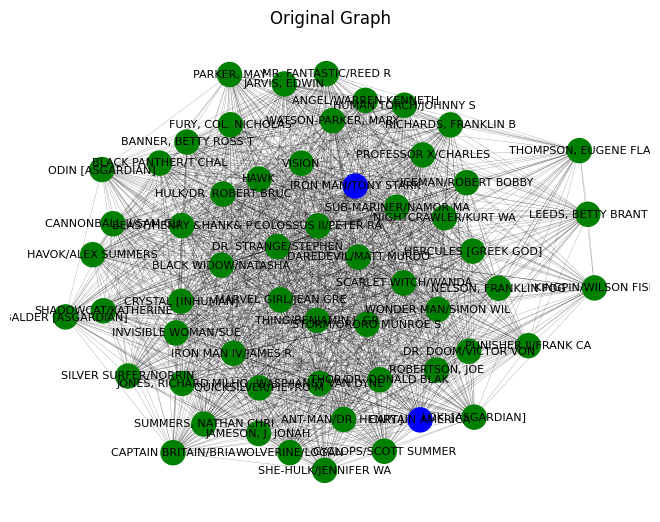

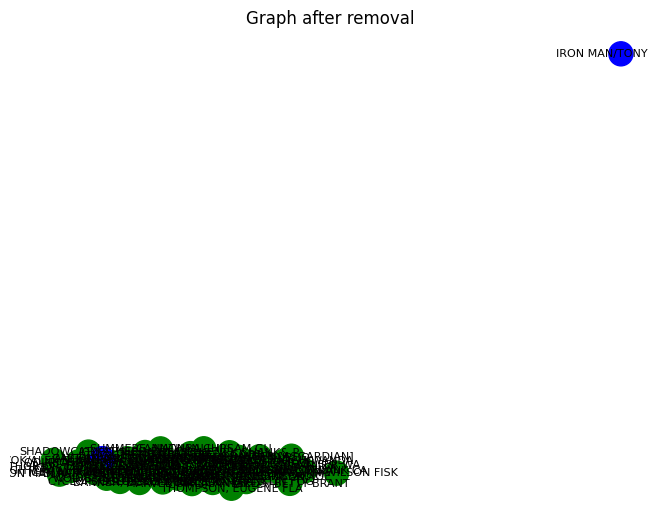

In [ ]:
test4.visualization()

### Functionality 5 - Extracting Communities

First of all we want to reduce the dimensionality of our graphs. To do that we create a list of the most common heroes containing the name of the heroes appearing in the biggest number of comics.

In [ ]:
def top_N(df, N):return df.groupby('hero').count().sort_values(['comic'], ascending = False).iloc[:N]

In [ ]:
topHeroes = top_N(edges, 50)

In [ ]:
topHeroes

,comic
hero,
SPIDER-MAN/PETER PARKER,1577
CAPTAIN AMERICA,1334
IRON MAN/TONY STARK,1150
THING/BENJAMIN J. GR,963
THOR/DR. DONALD BLAK,956
HUMAN TORCH/JOHNNY S,886
MR. FANTASTIC/REED R,854
HULK/DR. ROBERT BRUC,835
WOLVERINE/LOGAN,819


Now that we have a list of heroes, we use it to create a subgraph from the biggest graph. In this case we will use the graph1 which is the one created from the hero-network dataset.

In [ ]:
subgraph1 = graph1.subgraph(topHeroes.index.tolist())

In [ ]:
nx.info(subgraph1)

C:\Users\abell\AppData\Local\Temp\ipykernel_10468\2467672104.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(subgraph1)


'Graph with 48 nodes and 1099 edges'

In [ ]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [ ]:
def girvan_newman(graph):
    # find number of connected components
    cc = nx.connected_components(graph)
    cc_count = nx.number_connected_components(graph)
    removed=0

    while(cc_count == 1):
        removed+=1
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        cc = nx.connected_components(graph)
        cc_count = nx.number_connected_components(graph)

    return cc, removed

This is the complete funcion, taking in input the number of heroes required, two heroes and a graph, and giving back the communities, the number of nodes that have been removed, and whether the two heroes are in the same communities or not.

In [ ]:
def extract_communities(n, graph, hero_1, hero_2):
    topHeroes = top_N(edges, n)
    subgraph1 = graph1.subgraph(topHeroes.index.tolist()).copy()
    sg, removed = girvan_newman(subgraph1)
    communities = []
    for c in sg:
        communities.append(list(c))
    same_community = False
    for i in communities:
        if hero_1 in i and hero_2 in i:
            same_community = True
            break

    return communities, removed, same_community

First trial of the functionality picking at random two heroes from the list of the most common ones.

In [ ]:
hero1 = 'SCARLET WITCH/WANDA'
hero2 = 'HERCULES [GREEK GOD]'
n=50
communities, removed, same_community = extract_communities(n, subgraph1, hero1, hero2)

In [ ]:
removed

41

In [ ]:
communities

[['WONDER MAN/SIMON WIL',
  'STORM/ORORO MUNROE S',
  'INVISIBLE WOMAN/SUE',
  "BLACK PANTHER/T'CHAL",
  'HULK/DR. ROBERT BRUC',
  'ROBERTSON, JOE',
  'SHADOWCAT/KATHERINE',
  'FURY, COL. NICHOLAS',
  'BLACK WIDOW/NATASHA',
  'NIGHTCRAWLER/KURT WA',
  'MR. FANTASTIC/REED R',
  'CAPTAIN AMERICA',
  'MARVEL GIRL/JEAN GRE',
  'WATSON-PARKER, MARY',
  'THING/BENJAMIN J. GR',
  'ANT-MAN/DR. HENRY J.',
  'HERCULES [GREEK GOD]',
  'JAMESON, J. JONAH',
  'DR. STRANGE/STEPHEN',
  'HUMAN TORCH/JOHNNY S',
  'PROFESSOR X/CHARLES',
  'DAREDEVIL/MATT MURDO',
  'ANGEL/WARREN KENNETH',
  'PARKER, MAY',
  'RICHARDS, FRANKLIN B',
  'DR. DOOM/VICTOR VON',
  'QUICKSILVER/PIETRO M',
  'ODIN [ASGARDIAN]',
  'SCARLET WITCH/WANDA',
  'NELSON, FRANKLIN FOG',
  'THOR/DR. DONALD BLAK',
  'SHE-HULK/JENNIFER WA',
  'SUB-MARINER/NAMOR MA',
  'WOLVERINE/LOGAN',
  'PUNISHER II/FRANK CA',
  'HAWK',
  'CYCLOPS/SCOTT SUMMER',
  'VISION',
  'COLOSSUS II/PETER RA',
  'JONES, RICHARD MILHO',
  'JARVIS, EDWIN',
  'CAPTAIN B

In [ ]:
same_community

True

## 3. Frontend Implementation

### Visualization 5 - Visualize the communities

 - Print the number of links that should be removed to have the communities

In [ ]:
print(removed)

41


 - A table depicting the communities and the heroes that belong to each community

In [ ]:
comm1=communities[0]
comm2=communities[1]

print(len(comm1))
print(len(comm2))

47
1


In [ ]:
for i in range(len(comm1)-len(comm2)):
    comm2.append('NA')

In [ ]:
print(len(comm1))
print(len(comm2))

47
47


In [ ]:
d = {'comm1': comm1, 'comm2': comm2}
headers=['comm1', 'comm2']
dfcomm = pd.DataFrame(data=d)

In [ ]:
print(tabulate(dfcomm, headers=headers, floatfmt=".4f"))

    comm1                 comm2
--  --------------------  --------------------
 0  WONDER MAN/SIMON WIL  CANNONBALL II/SAM GU
 1  STORM/ORORO MUNROE S  NA
 2  INVISIBLE WOMAN/SUE   NA
 3  BLACK PANTHER/T'CHAL  NA
 4  HULK/DR. ROBERT BRUC  NA
 5  ROBERTSON, JOE        NA
 6  SHADOWCAT/KATHERINE   NA
 7  FURY, COL. NICHOLAS   NA
 8  BLACK WIDOW/NATASHA   NA
 9  NIGHTCRAWLER/KURT WA  NA
10  MR. FANTASTIC/REED R  NA
11  CAPTAIN AMERICA       NA
12  MARVEL GIRL/JEAN GRE  NA
13  WATSON-PARKER, MARY   NA
14  THING/BENJAMIN J. GR  NA
15  ANT-MAN/DR. HENRY J.  NA
16  HERCULES [GREEK GOD]  NA
17  JAMESON, J. JONAH     NA
18  DR. STRANGE/STEPHEN   NA
19  HUMAN TORCH/JOHNNY S  NA
20  PROFESSOR X/CHARLES   NA
21  DAREDEVIL/MATT MURDO  NA
22  ANGEL/WARREN KENNETH  NA
23  PARKER, MAY           NA
24  RICHARDS, FRANKLIN B  NA
25  DR. DOOM/VICTOR VON   NA
26  QUICKSILVER/PIETRO M  NA
27  ODIN [ASGARDIAN]      NA
28  SCARLET WITCH/WANDA   NA
29  NELSON, FRANKLIN FOG  NA
30  THOR/DR. DONALD BLAK  NA
31  

 - Plot the original graph

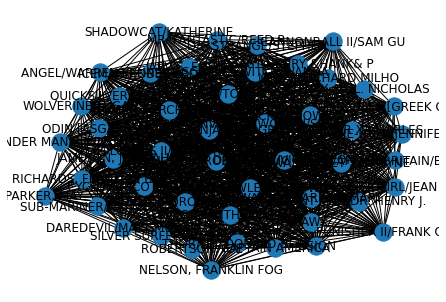

In [ ]:
nx.draw(subgraph1, with_labels=True)

 - Plot the graph showing the communities in the network

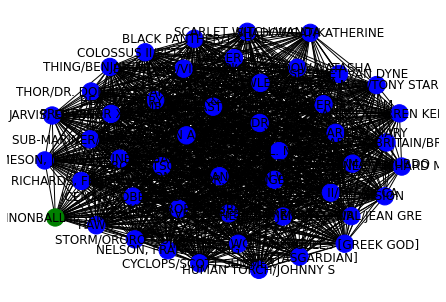

In [ ]:
color_map = []
for node in subgraph1:
    if node in communities[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(subgraph1, node_color=color_map, with_labels=True)
plt.show()

 - Plot the final graph and identify the community/communities of Hero_1 and Hero_2

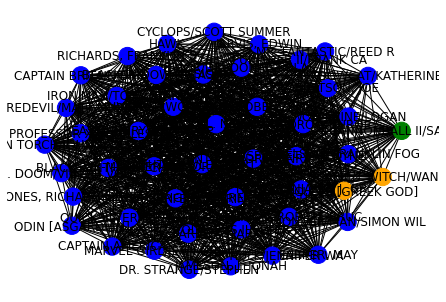

In [ ]:
color_map = []
for node in subgraph1:
    if node in communities[0]:
        if node==hero1 or node==hero2:
            color_map.append('orange')
        else:
            color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(subgraph1, node_color=color_map, with_labels=True)
plt.show()

# Algorithmic Question

The idea we had to solve this problem is to model it through a directed graph whit nine nodes and edges connecting those nodes expressing with their weights the direction they're pointing. The directions are 'U', 'D', 'R', 'L', as the input examples suggested. 

Then we defined a first naive approach given a strong assumption that simplifies the problem. 


<div align='center'> <b><i> EACH DIRECTION IN THE INPUT STRING CAN ONLY BE RUN ACROSS ONE TIME </i></b></div>

This is a very approximative pseudo-code for our idea:

```
PathChecker(INPUT: G:graph, N: node, Directions: str, OUTPUT: Boolean):
    if len(Directions) == 0:
        return(any in G(node).weight == Directions[0])
    else:
        if any in G(node).weights == Directions[0]:
            edge <- edge in G.edges: edge.weight == Directions[0]
            N <- edge[1]
            return(PathChecker(G, N, Directions[1:]))
        else:
            return False
```

We implemented a class to deal with directed graphs from scratch:
- `__init__` is the class builder that takes in input a list of nodes and a dictionary for the edges and builds a `adDict` for the adjacency to have a self-representation. It also initializes a variable called `visited` that is useful in subsequent methods;
- `getNeighbours` extract the neighbours of a node through the adjacency matrix;
- `getConnections` returns as a list the exit-star of a node. In other words it outputs the edges that have the tail in the node. 
- `findDirection` check if from a node there's an edge pointing in a certain direction, and eventually outputs that edge.
- `visitedInitialization` initialize the `self.visited` to a list containing the source of a walk. It is useful to take track of the visited node, since one of the constraints is that the walk on the phone-polyline must not pass over an already touched node. 
- `checkPath` recursively leverages `findDirection` over a string of directions to check if exists a succession of directions path from a node.
- `countPath` counts how many paths are looping through all the nodes.

In [1]:
class Graph:
    def __init__(self, nodes:list, edges:dict):
        self.nodes = nodes
        self.edges = edges
        self.visited = None
        self.adDict = {node: [] for node in self.nodes}

        for (src, dst) in self.edges.keys():
            self.adDict[src].append(dst)
            self.adDict[dst].append(src)
    
    def getNeighbours(self, node):
        return self.adDict[node]
    
    def getConnections(self, node):
        return [edge for edge in self.edges.keys() if edge[0] == node]

    def findDirection(self, node, direction):
        for edge in self.getConnections(node):
            if self.edges[edge] == direction:
                return edge 
        return False
    
    def visitedInitialization(self,node):
        self.visited = [node]
    
    def checkPath(self, node, directions:str):
        if len(directions) == 1:
            if self.findDirection(node,directions):
                edge = self.findDirection(node, directions)
                pointed = edge[1]
                if pointed in self.visited:
                    return False
                else:
                    return True
            else:
                return False
        else:
            if self.findDirection(node, directions[0]):
                edge = self.findDirection(node, directions[0])
                pointed = edge[1]
                if pointed in self.visited:
                    return False
                else:
                    self.visited.append(pointed)
                    return self.checkPath(edge[1], directions[1:])
            else:
                return False

    def countPath(self, directions):
        count = 0
        for node in self.nodes:
            self.visitedInitialization(node)
            count += int(self.checkPath(node, directions))
        return count

This is the instance of the graph that modelize our problem: as we can see we have redundancies in the edge list that could have been solved with an undirected graph, but this instanciation is more expressive for our problem.

In [2]:
phone_polyline = Graph([1,2,3,4,5,6,7,8,9],{(1,2):'R',(2,1):'L',
                                            (4,1):'U',(1,4):'D',
                                            (2,3):'R',(3,2):'L',
                                            (2,5):'D',(5,2):'U',
                                            (3,6):'D',(6,3):'U',
                                            (4,7):'D',(7,4):'U',
                                            (4,5):'R',(5,4):'L',
                                            (5,6):'R',(6,5):'L',
                                            (5,8):'D',(8,5):'U',
                                            (6,9):'D',(9,6):'U',
                                            (7,8):'R',(8,7):'L',
                                            (8,9):'R',(9,8):'L'})

Now we can modify our initial assumption:

<div align='center'> <b><i> EACH DIRECTION IN THE INPUT STRING CAN BE RUN ACROSS ONCE OR TWICE </i></b></div>

This is a consequence of this part of the assignment *Alex learned the direction of each line segment by looking at her hand while unlocking her phone. He didn't pay much attention to the length of each line segment*: the shape of the polyline imposes constraints on the length of each line segment, that can't be longer of 2 pointing the same directions. 


That leads to another recursive question: we need to define all the possible paths that come down from a string of directions. In our `Solution` class we implemented a `directionsRecombiner` method that does so. Let's see an example:

In [16]:
sol = Solution(phone_polyline)
sol.directionsRecombiner('DRU')

['DRU', 'DRUU', 'DRRU', 'DRRUU', 'DDRU', 'DDRUU', 'DDRRU', 'DDRRUU']

As a binary splitting problem from a string of length $L$ we get $2^L$ possible paths. We are going to count how many of them are actually admittable on every node of the graph as the source to get the solution to the problem.

In [9]:
class Solution:
    def __init__(self, graph: Graph):
        self.graph = graph
    
    def directionsRecombiner(self, directions):
        if len(directions) == 1:
            return [directions, 2*directions]
        else:
            list1 = [directions[0]+ricomb for ricomb in self.directionsRecombiner(directions[1:])]
            list2 = [2*directions[0]+ricomb for ricomb in self.directionsRecombiner(directions[1:])]
            return list1 + list2

    def finalCounter(self, directions):
        final_count = 0
        for direction in self.directionsRecombiner(directions):
            final_count += self.graph.countPath(direction)
        return final_count

In [10]:
sol = Solution(phone_polyline)
print(sol.finalCounter('DRU'))
print(sol.finalCounter('R'))
print(sol.finalCounter('LDRDLUL'))

15
9
0
